In [1]:
import numpy as np
import pandas as pd

import os
from glob import glob

import pydicom as dicom
import cv2
import SimpleITK as sitk
from tqdm import tqdm
import matplotlib.pyplot as plt

from preprocess import create_lung_mask, apply_lung_mask

In [2]:
data_path = "/home/samsmu/Data/Lung/CT"
luna_path = data_path + "/LUNA16" 
luna_subset_path = luna_path + "/all"
file_list=glob(luna_subset_path + "/*.mhd")
output_path = data_path + "/Temp"

In [3]:
#####################
#
# Helper function to get rows in data frame associated 
# with each file
def get_filename(case):
    global file_list
    for f in file_list:
        if case in f:
            return(f)
#
# The locations of the nodes
df_node = pd.read_csv(luna_path + "/annotations.csv")
df_node["file"] = df_node["seriesuid"].apply(get_filename)
df_node = df_node.dropna()

In [4]:
def make_mask(center,diam,z,width,height,spacing,origin):
    '''
Center : centers of circles px -- list of coordinates x,y,z
diam : diameters of circles px -- diameter
widthXheight : pixel dim of image
spacing = mm/px conversion rate np array x,y,z
origin = x,y,z mm np.array
z = z position of slice in world coordinates mm
    '''
    mask = np.zeros([height,width]) # 0's everywhere except nodule swapping x,y to match img
    #convert to nodule space from world coordinates

    # Defining the voxel range in which the nodule falls
    v_center = (center-origin)/spacing
    v_diam = int(diam/spacing[0]+5)
    v_xmin = np.max([0,int(v_center[0]-v_diam)-5])
    v_xmax = np.min([width-1,int(v_center[0]+v_diam)+5])
    v_ymin = np.max([0,int(v_center[1]-v_diam)-5]) 
    v_ymax = np.min([height-1,int(v_center[1]+v_diam)+5])

    v_xrange = range(v_xmin,v_xmax+1)
    v_yrange = range(v_ymin,v_ymax+1)

    # Convert back to world coordinates for distance calculation
    x_data = [x*spacing[0]+origin[0] for x in range(width)]
    y_data = [x*spacing[1]+origin[1] for x in range(height)]

    # Fill in 1 within sphere around nodule
    for v_x in v_xrange:
        for v_y in v_yrange:
            p_x = spacing[0]*v_x + origin[0]
            p_y = spacing[1]*v_y + origin[1]
            if np.linalg.norm(center-np.array([p_x,p_y,z]))<=diam:
                mask[int((p_y-origin[1])/spacing[1]),int((p_x-origin[0])/spacing[0])] = 1.0
    return(mask)

In [5]:
def matrix2int16(matrix):
    ''' 
matrix must be a numpy array NXN
Returns uint16 version
    '''
    m_min= np.min(matrix)
    m_max= np.max(matrix)
    matrix = matrix-m_min
    return(np.array(np.rint( (matrix-m_min)/float(m_max-m_min) * 65535.0),dtype=np.uint16))

############

### 01. Getting the nodule position in the mhd files

In [7]:
#####
#
# Looping over the image files
#
for fcount, img_file in enumerate(tqdm(file_list)):
    mini_df = df_node[df_node["file"]==img_file] #get all nodules associate with file
    if mini_df.shape[0]>0: # some files may not have a nodule--skipping those 
        # load the data once
        itk_img = sitk.ReadImage(img_file) 
        img_array = sitk.GetArrayFromImage(itk_img) # indexes are z,y,x (notice the ordering)
        num_z, height, width = img_array.shape        #heightXwidth constitute the transverse plane
        origin = np.array(itk_img.GetOrigin())      # x,y,z  Origin in world coordinates (mm)
        spacing = np.array(itk_img.GetSpacing())    # spacing of voxels in world coor. (mm)
        # go through all nodes (why just the biggest?)
        for node_idx, cur_row in mini_df.iterrows():       
            node_x = cur_row["coordX"]
            node_y = cur_row["coordY"]
            node_z = cur_row["coordZ"]
            diam   = cur_row["diameter_mm"]
            # just keep 3 slices
            imgs = np.ndarray([3,height,width],dtype=np.float32)
            masks = np.ndarray([3,height,width],dtype=np.uint8)
            center = np.array([node_x, node_y, node_z])   # nodule center
            v_center = np.rint((center-origin)/spacing)  # nodule center in voxel space (still x,y,z ordering)
            slices_ind = np.arange(int(v_center[2])-1,int(v_center[2])+2).clip(0, num_z-1)
            for i, i_z in enumerate(slices_ind): # clip prevents going out of bounds in Z
                mask = make_mask(center, diam, i_z*spacing[2]+origin[2],
                                 width, height, spacing, origin)
                masks[i] = mask
                imgs[i] = img_array[i_z]
            np.save(os.path.join(output_path,"images_%04d_%04d.npy" % (fcount, node_idx)),imgs)
            np.save(os.path.join(output_path,"masks_%04d_%04d.npy" % (fcount, node_idx)),masks)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 267/267 [01:14<00:00,  3.60it/s]


In [9]:
imgs = np.load(output_path+'/images_0001_0454.npy')
masks = np.load(output_path+'/masks_0001_0454.npy')

In [10]:
#plt.imshow(masks[0], cmap = 'gray')
mask = masks[0].astype(np.uint8)
contours, hierarhy = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
image = imgs[0]
image_copy = image.copy()
cv2.drawContours(image=image_copy, contours=contours, contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)

array([[ -993.,  -988.,  -995., ...,  -985.,  -977.,  -972.],
       [ -991.,  -984.,  -985., ...,  -989.,  -985.,  -985.],
       [ -998.,  -993.,  -989., ...,  -989.,  -987., -1000.],
       ...,
       [-1000., -1000., -1000., ...,  -842., -1000., -1000.],
       [ -988.,  -985.,  -987., ..., -1000., -1000., -1000.],
       [ -985.,  -980.,  -982., ..., -1000., -1000., -1000.]],
      dtype=float32)

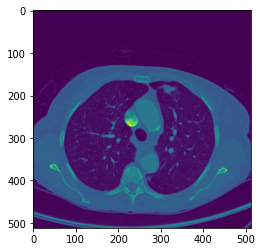

In [11]:
plt.imshow(imgs[2])

image 0


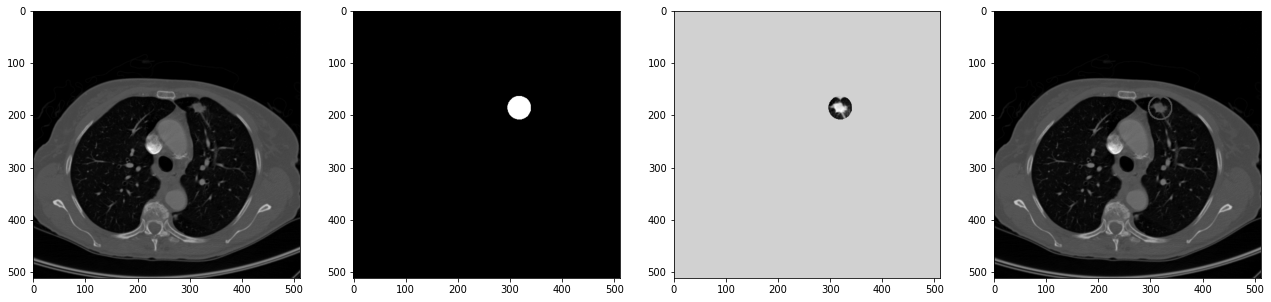

image 1


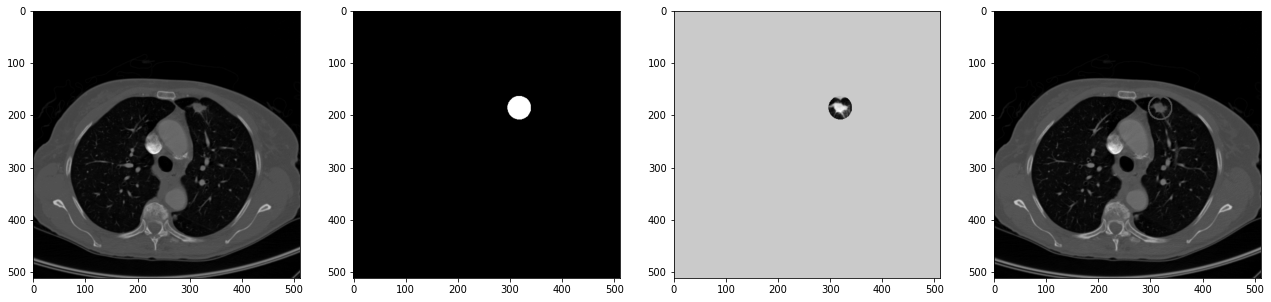

image 2


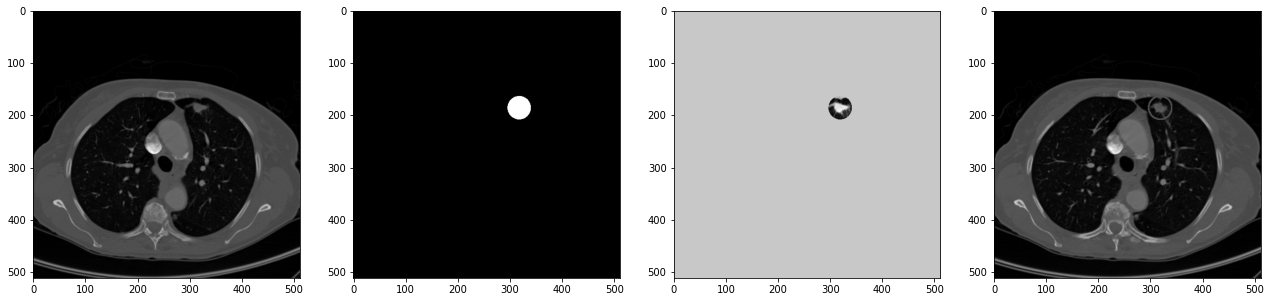

In [12]:
for i in range(len(imgs)):
    print ("image %d" % i)
    fig,ax = plt.subplots(1,4, figsize=[22,8])
    ax[0].imshow(imgs[i],cmap='gray')
    ax[1].imshow(masks[i],cmap='gray')
    ax[2].imshow(imgs[i]*masks[i], cmap='gray')
    
    mask = masks[0].astype(np.uint8)
    contours, hierarhy = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    image = imgs[0]
    image_roi = image.copy()
    cv2.drawContours(image=image_roi, contours=contours, contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)    
    ax[3].imshow(image_roi, cmap='gray')
    plt.show()
  

### 2. Isolation of the Lung Region of Interest to Narrow Our Nodule Search

In [6]:
import numpy as np
from skimage import morphology
from skimage import measure
from sklearn.cluster import KMeans
from skimage.transform import resize
from glob import glob

In [7]:
data_path = "/home/samsmu/Data/Lung/CT"
working_path = data_path + "/Temp/"
file_list = glob(working_path + "/images_*.npy")

ImportError: cannot import name 'apply_lung_mask' from 'preprocess' (/home/samsmu/Code/NTI/preprocess.py)

In [ ]:
for img_file in file_list:
    # I ran into an error when using Kmean on np.float16, so I'm using np.float64 here
    imgs_to_process = np.load(img_file).astype(np.float64) 
    print ("on image", img_file)
    for i in range(len(imgs_to_process)):
        img = imgs_to_process[i]
        mask = create_lung_mask(img)
        imgs_to_process[i] = mask
    np.save(img_file.replace("images","lungmask"),imgs_to_process)

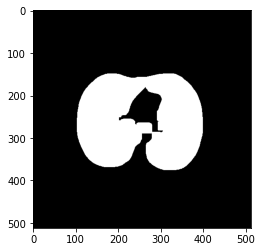

In [17]:
plt.imshow(imgs_to_process[-3], cmap = "gray")

### Appling the ROI mask

In [ ]:
file_list=glob(working_path+"lungmask_*.npy")
out_images = []      #final set of images
out_nodemasks = []   #final set of nodemasks
for fname in file_list:
    print ("working on file ", fname)
    imgs_to_process = np.load(fname.replace("lungmask","images"))
    masks = np.load(fname)
    node_masks = np.load(fname.replace("lungmask","masks"))
    for i in range(len(imgs_to_process)):
        img = imgs_to_process[i]
        mask = masks[i]
        node_mask = node_masks[i]
        
        new_img, new_node_mask = apply_lung_mask(img, mask, node_mask)
        if new_img is None:
            pass
        else:
            out_images.append(new_img)
            out_nodemasks.append(new_node_mask)           

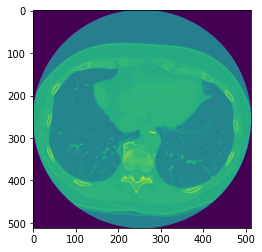

In [31]:
plt.imshow(imgs_to_process[0])

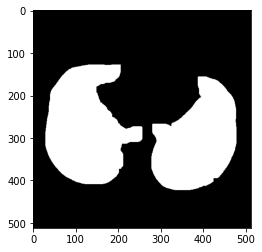

In [32]:
plt.imshow(masks[0], cmap = "gray")

In [27]:
num_images = len(out_images)
#
#  Writing out images and masks as 1 channel arrays for input into network
#
final_images = np.ndarray([num_images,1,512,512],dtype=np.float32)
final_masks = np.ndarray([num_images,1,512,512],dtype=np.float32)
for i in range(num_images):
    final_images[i,0] = out_images[i]
    final_masks[i,0] = out_nodemasks[i]

rand_i = np.random.choice(range(num_images),size=num_images,replace=False)
test_i = int(0.3*num_images)
np.save(working_path+"trainImages.npy",final_images[rand_i[test_i:]])
np.save(working_path+"trainMasks.npy",final_masks[rand_i[test_i:]])
np.save(working_path+"testImages.npy",final_images[rand_i[:test_i]])
np.save(working_path+"testMasks.npy",final_masks[rand_i[:test_i]])

In [46]:
np.max(final_images[0][0])

0.7336034

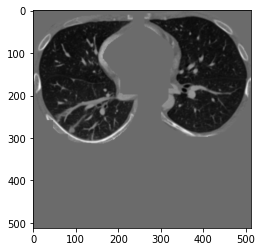

In [30]:
plt.imshow(final_images[20][0], cmap = "gray")

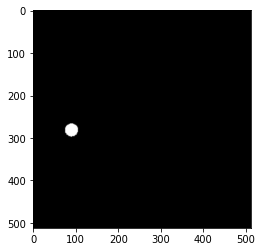

In [33]:
plt.imshow(final_masks[20][0], cmap = "gray")